# Annotation and analysis of ChIP-seq and RNA-seq results

Results from the Galaxy workflow and additional processing with the bash notebook are imported and used to annotate genomic results to genes, adding functional annotation, as well as calculate some statistics and generate figures. This notebook will use an imported script containing custom functions.


In [1]:
jup_wd <- "~/work/jupyter-res/"
gal_wd <- "~/work/galaxy-res/"
setwd(jup_wd)

In [2]:
# import functions from accessory file
my_funs <- "~/notebooks/functions.R"
source(my_funs)

In [3]:
suppressMessages(library(GenomicFeatures)); suppressMessages(library(ChIPpeakAnno)); library(tidyverse); suppressMessages(library(GGally))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

Warning message:
"package 'tidyr' was built under R version 3.6.2"
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse()   masks Biostrings::collapse(), IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ purrr::compact()    masks XVector::compact()
✖ dplyr::desc()       masks IRanges::desc()
✖ tidyr::expand()     masks S4Vectors::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::first()      masks S4Vectors::first()
✖ dplyr::lag()        masks stats::lag()
✖ ggplot2::Position() masks BiocGenerics::Position(), base::Position()
✖ purrr::reduce()     masks GenomicRanges::reduce(), IRanges::reduce()
✖ dplyr::rename()     masks S4Vectors::rename()
✖ dplyr::select()   

#### Load common resources

In [4]:
my_gff <- "~/work/lib/test_genome/genes.gff"
my_ann <- read_tsv("~/work/lib/test_genome/genes.annot", col_types = cols())
head(my_ann, 1)

ID,chr,start,end,Name,locus_type,symbol,Alias,full_name,Note,curator_summary,computational_description,Dbxref,description,nochangenat-description
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
AT1G68030,chr1,378,1803,AT1G68030,protein_coding,NA,NA,NA,RING/FYVE/PHD zinc finger superfamily protein,NA,"RING/FYVE/PHD zinc finger superfamily protein; FUNCTIONS IN: zinc ion binding; INVOLVED IN: biological_process unknown; LOCATED IN: cellular_component unknown; CONTAINS InterPro DOMAIN/s: Zinc finger, PHD-type, conserved site (InterPro:IPR019786), Zinc finger, PHD-type (InterPro:IPR001965), Zinc finger, FYVE/PHD-type (InterPro:IPR011011); BEST Arabidopsis thaliana protein match is: RING/FYVE/PHD zinc finger superfamily protein (TAIR:AT1G14770.2); Has 83 Blast hits to 71 proteins in 24 species: Archae - 0; Bacteria - 0; Metazoa - 2; Fungi - 18; Plants - 63; Viruses - 0; Other Eukaryotes - 0 (source: NCBI BLink).",locus:2200201,NA,NA


Indicate the name of the column in the annotation file that contains the gene identifiers.

In [5]:
gene_col <- "Name"

In [6]:
# load gene annotations in bed format
ann_bed <- "~/work/lib/test_genome/genes.bed"
ann_bed <- read_tsv(ann_bed, col_types = cols(), col_names = c("c1","c2","c3","feature"))
head(ann_bed, 3)

c1,c2,c3,feature
<chr>,<dbl>,<dbl>,<chr>
chr1,377,1803,AT1G68030
chr1,2863,5263,AT1G68040
chr1,8638,10907,AT1G68050


## 1 - Sample-sample comparisons: Scatterplot
One way to assess quality of replicated samples is to see their pair-wise correlation. Here we used a function to draw a scatterplot of counts on bins or genes, count density plots and Spearman correlation.

In [7]:
options(repr.plot.width=7, repr.plot.height=6)

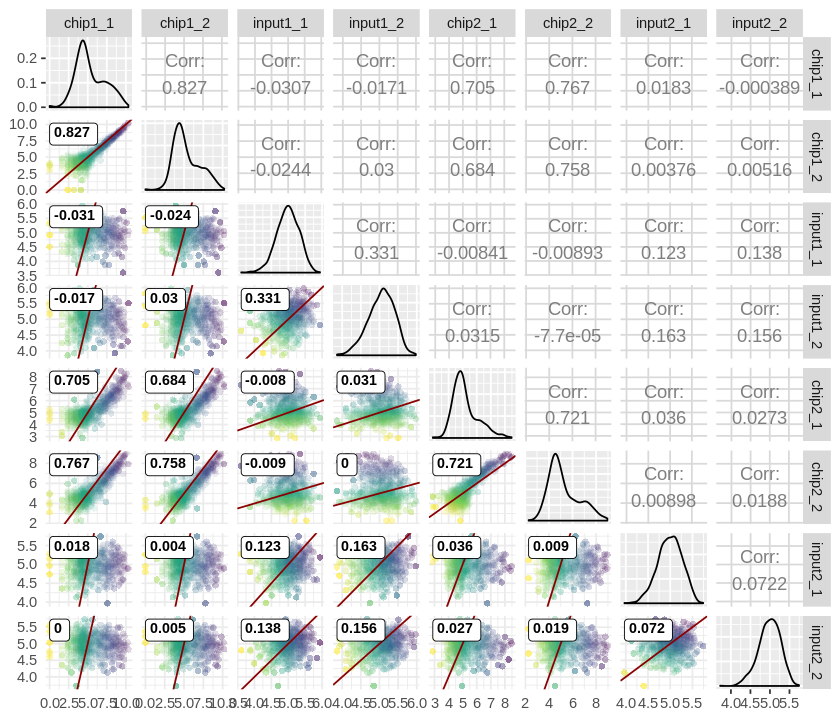

In [8]:
### ChIP-Seq
cnt <- paste0(jup_wd, "ChIP_counts.tab")
cnt_sf <- paste0(jup_wd, "ChIP_counts_sf.tab")

df <- read_tsv(cnt, col_types = cols()) %>% as.data.frame
rownames(df) <- df %>% select(1:3) %>% unite(bin) %>% pull
colnames(df) <- df %>% colnames %>% str_replace_all("'","") %>% str_replace_all(".bam","")
df <- df %>% select(4:ncol(df))

df_sf <- read.table(cnt_sf, header = T, row.names = 1)

df <- sapply(colnames(df), function(x) as.matrix(df)[rownames(df), x] * df_sf[x,]) %>%
  as.data.frame(., row.names = rownames(.)) %>%
  filter(rowSums(.) > ncol(.))

p <- GGally::ggpairs(log2(df+1),
                    1:ncol(df),
                    lower = list(continuous = GGscatterPlot),
                    upper = list(continuous = wrap("cor", method= "spearman")))
p

ggsave(p, file=paste0(jup_wd, "figures/corr_chipseq.tiff"), width = ncol(df) + 1, height = ncol(df) + 1, compression="lzw")

Warning message:
"Missing column names filled in: 'X1' [1]"


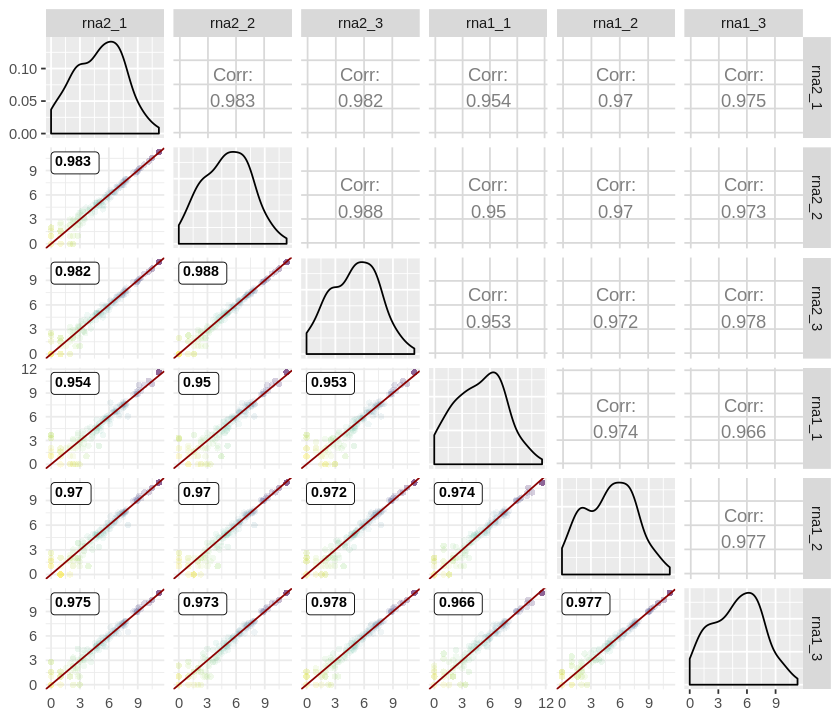

In [9]:
### RNA-Seq
cnt <- list.files(paste0(gal_wd,"rnaseq/"), pattern = ".*counts.tabular$", full.names = T)
df <- read_tsv(cnt, col_types = cols()) %>% as.data.frame
rownames(df) <- df %>% pull(1)
df <- df %>% select(2:ncol(df)) %>% filter(rowSums(.) > ncol(.))

p <- GGally::ggpairs(log2(df+1),
                1:ncol(df),
                lower = list(continuous = GGscatterPlot),
                upper = list(continuous = wrap("cor", method= "spearman")))
p

ggsave(p, file=paste0(jup_wd, "figures/corr_rnaseq.tiff"), width = ncol(df) + 1, height = ncol(df) + 1, compression="lzw")

## 2 - Annotation of ChIP-Seq peaks
### Annotation of peak calling results

On the bash notebook, raw peaks were filtered by log2FC between ChIP and INPUT sequencing files before running MAnorm. Here, these files are annotated to overlapped genes with ChIPpeakAnno and joined with functional annotations. Marked genes are printed to a list.

In [10]:
# find bed files
bed_1 <- list.files(paste0(gal_wd, "chipseq1/"), pattern = "*FCgt.*.bed", full.names = T)
bed_2 <- list.files(paste0(gal_wd, "chipseq2/"), pattern = "*FCgt.*.bed", full.names = T)

# annotate peaks
anno_1 <- epic_annot(bed_1, my_gff, my_ann, gene_col)
anno_2 <- epic_annot(bed_2, my_gff, my_ann, gene_col)

# save annotation results
write_annot(anno_1, paste0(jup_wd, str_replace(basename(bed_1),".bed","-anno.tsv")))
write_annot(anno_2, paste0(jup_wd, str_replace(basename(bed_2),".bed","-anno.tsv")))

# print gene IDs as input to AgriGO or similar software
anno_1 %>% pull(feature) %>% cat(file = str_replace(basename(bed_1),".bed","-genelist.txt"), sep = '\n')
anno_2 %>% pull(feature) %>% cat(file = str_replace(basename(bed_1),".bed","-genelist.txt"), sep = '\n')

Warning message in formatStrand(strand):
"All the characters for strand, 
            other than '1', '-1', '+', '-' and '*', 
            will be converted into '*'."
Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK

Warning message in formatStrand(strand):
"All the characters for strand, 
            other than '1', '-1', '+', '-' and '*', 
            will be converted into '*'."
Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK



### Annotation of MAnorm combined peaks
The table of results generated by MAnorm are annotated to include the names and log2FC of original peaks in addition to functional annotations. 

In [11]:
manorm_dir <- paste0(jup_wd, "manorm-1vs2/")
manorm_res <- list.files(manorm_dir, pattern = ".*.xls", full.names = T)
manorm_comp <- paste(str_split(basename(manorm_res), "_")[[1]][1:3], collapse = "_")

options(warn=-1)
grMN <- combine_epic(bed_1, bed_2, manorm_res)

res_anpe <- annotate_peaks(my_gff, grMN)
head(res_anpe, 3)

anno_df <- add_func_annot(res_anpe, my_ann, gene_col)

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK



,seqnames,start,end,width,strand,peaks_1,FC_1,peaks_2,FC_2,summit,⋯,normalized_read_density_in_2,peak,feature,start_position,end_position,feature_strand,insideFeature,distancetoFeature,shortestDistance,fromOverlappingOrNearest
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<fct>,<dbl>,<int>,<chr>
X01.AT1G68150,chr1,43401,44799,1399,*,island_4,1.182397,NA,NA,699,⋯,74.85750,01,AT1G68150,43949,45791,+,overlapStart,-548,548,Overlapping
X02.NA,chr1,83801,85199,1399,*,island_8,1.251366,NA,NA,699,⋯,77.84163,02,NA,NA,NA,NA,NA,NA,NA,NA
X03.AT1G68330,chr1,111401,111599,199,*,island_13,1.363687,NA,NA,99,⋯,45.55382,03,AT1G68330,110723,112469,+,inside,678,678,Overlapping


In [12]:
write_annot(anno_df, paste0(manorm_dir, paste0("manorm_annot_",manorm_comp,".tsv")))

## 3 - Processing of RNA-Seq results
The major results after RNA-Seq analysis are the table of normalized read counts and the differential expression analysis results, both ourput of DESeq2.

### Read counts
Counts are loaded and transformed into z-scores. This script works with 3 replicates from 2 samples named as `rna{sample}_{rep}`.

In [13]:
cnt_res <- list.files(paste0(gal_wd, "rnaseq/"), pattern = ".*counts.tabular$", full.names = T)

cnt_res <- read_tsv(cnt_res, col_types = cols()) %>% 
    rename(feature = X1)  %>% 
    gather(tmp, value, -feature) %>% 
    separate(tmp, c("sample", "rep")) %>% 
    mutate(sample = str_replace(sample, "rna", "")) %>% 
    spread(rep, value) %>% 
    mutate(counts = rowSums(.[3:5]), sd = RowSD(.[3:5]))

Warning message:
"Missing column names filled in: 'X1' [1]"


#### Calculation of z-scores
Counts were categorized by expression level and the lists of genes exported locally.

In [14]:
cnt_res <- cnt_res %>% 
    filter(counts != 0) %>% 
    group_by(sample) %>%
    mutate(log = log10(counts)) %>% 
    mutate(tmean = mean(log), tsd = sd(log)) %>% 
    mutate(z = (log - tmean) / tsd) %>% 
    full_join(cnt_res) %>%
    mutate(category = cut(z, breaks=c(-Inf, -0.5, 0.5, Inf), labels=c("low","medium","high"))) %>% 
    mutate(category = replace_na(as.character(category), "no_expr"))
cnt_res$category <- factor(cnt_res$category, levels = c("no_expr", "low", "medium", "high"))

head(cnt_res, 3)

Joining, by = c("feature", "sample", "1", "2", "3", "counts", "sd")



feature,sample,1,2,3,counts,sd,log,tmean,tsd,z,category
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
AT1G09017,1,0.000000,0.0000000,1.016482,1.0164822,0.5868663,0.007099768,1.552702,1.035697,-1.492331,low
AT1G09017,2,0.000000,0.9909798,0.000000,0.9909798,0.5721425,-0.003935176,1.548236,1.028307,-1.509443,low
AT1G09027,1,2.031232,0.0000000,1.016482,3.0477138,1.0156159,0.483974175,1.552702,1.035697,-1.031893,low


In [15]:
# print genes from each expression category by separate
dir_path = paste0(jup_wd, "gene_expr_lists/")
dir.create(dir_path, showWarnings = FALSE)

my_feat <- with(cnt_res, split(feature, list(sample, category)))
for (n in names(my_feat)) {
    cat(paste(n, length(my_feat[[n]]), sep = "\t"), sep="\n")
    cat(my_feat[[n]], file= paste0(dir_path,"sample",n,".txt"), sep="\n")
}

1.no_expr	137
2.no_expr	133
1.low	62
2.low	63
1.medium	50
2.medium	51
1.high	63
2.high	65


### Differential expression results
Results from DESeq2 are loaded and combined with counts and MAnorm results.

In [16]:
deg_res <- list.files(paste0(gal_wd, "rnaseq/"), pattern = ".*table.tabular", full.names = T)

deg_res <- read_tsv(deg_res, col_names = c("feature", "BaseMean", "DElog2FC", "StdErr", "WaldStats", "Pvalue", "DEpadj"), col_types = cols()) %>%
    select(feature, DElog2FC, DEpadj) %>%
    mutate(DElog2FC = replace_na(DElog2FC, 0), DEdir = if_else(DElog2FC < 0, "down", if_else(DElog2FC == 0, "NA", "up")))

# number of total genes and inspection of table
nrow(deg_res)
head(deg_res, 2)

[1] 312

feature,DElog2FC,DEpadj,DEdir
<chr>,<dbl>,<dbl>,<chr>
AT1G68560,-1.5439626,6.893452e-27,down
AT1G69250,-0.9544219,1.697757e-03,down


Results of read counts are gathered by samples and combined with the above output of DESeq2 to generate a table with one row per gene and one column for each metric.
In addition, values related to differential gene expression are added to the annotated output of MAnorm.

In [17]:
cnt_res %>% select(feature, sample, counts, sd, expr_lvl = category) %>% 
        gather(variable, value, -(feature:sample)) %>% 
        unite(temp, variable, sample, sep = "-") %>%
        spread(temp, value) %>% 
        left_join(deg_res, by = "feature") %>% 
        select(1,2,6,4,3,7,5,8,9,10) %>%
        write_tsv(paste0(jup_wd, "rnaseq_res.tsv"))

anno_df %>% left_join(deg_res, by = "feature") %>%
        write_annot(paste0(manorm_dir, "manorm_annot_1vs2_deg.tsv"))

Warning message:
"attributes are not identical across measure variables;
they will be dropped"


## 4 - Combination of ChIP-Seq and RNA-Seq results
Annotated MAnorm results table is reorganized to include a column for samples and joined with RNA-seq results.


In [18]:
## data wrangling of annotated manorm results
ann_res <- res_anpe %>% select(feature, contains("1"), contains("2"), peak, Peak_Group, insideFeature, M_value, P_value) %>% 
    rename(density_1 = normalized_read_density_in_1, density_2 = normalized_read_density_in_2) %>%  
    gather(tmp, value, ends_with("1"), ends_with("2")) %>%
    separate(tmp, c("stat", "sample")) %>% 
    spread(stat, value)
head(ann_res, 2)

,feature,peak,Peak_Group,insideFeature,M_value,P_value,sample,density,FC,peaks
,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,AT1G08983,23,merged_common,includeFeature,0.39173,0.0007059939,1,210.48083,1.97400047683911,island_14
2,AT1G08983,23,merged_common,includeFeature,0.39173,0.0007059939,2,160.43165,1.33495670287183,island_16


In [19]:
# combination of chipseq with rnaseq results
all_res <- ann_res %>% 
    full_join(select(cnt_res, -`1`, -`2`, -`3`, -log, -tmean, -tsd), by = c("feature", "sample")) %>% 
    full_join(deg_res, by = "feature") %>%
    mutate(density = as.numeric(density), FC = as.numeric(FC))
all_res %>% arrange(peak) %>% head(2)

,feature,peak,Peak_Group,insideFeature,M_value,P_value,sample,density,FC,peaks,counts,sd,z,category,DElog2FC,DEpadj,DEdir
,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>
1,AT1G68150,01,1_unique,overlapStart,0.36463,0.008426291,1,96.38288,1.182397,island_4,0,0,NA,no_expr,0,NA,NA
2,AT1G68150,01,1_unique,overlapStart,0.36463,0.008426291,2,74.85750,NA,NA,0,0,NA,no_expr,0,NA,NA


### Expression levels on peaks by differential marking and expression
So far we created a table that summarizes the results from ChIP-Seq and RNA-Seq experiments. These are here organized to plot the expression category of sample 2 on peaks registered in sample 1. Thus, we record all peaks that appear in the treatment sample, including unique ones, and since this is a repressing mark, we expect increased expression on the control sample 2 on those regions where the mark in 1 has higher ChIP density (higher M value) than sample 2. For a soft filtering, we selected 0 as cutoff of the log2 fold change on both differential ChIP density and expression levels to keep all test data points, and a `p`-value of 0.1 for relaxed significance.

In [20]:
options(repr.plot.width = 5, repr.plot.height = 3)

First, all data is filtered to remove rows with missing data and only keep peaks that are annotated to a gene, additionally passing our cutoffs on fold change and `p`-value on both epigenetic mark and transcript levels between the two samples. Also, any result without a significant p-value is removed. All remaining genes are counted. On this set, the total number of genes covered by these peaks is counted.

In [21]:
mnFC <- 0
deFC <- 0
pval <- 0.1

filt_res <- filter(all_res, !is.na(category), !is.na(peaks), abs(M_value) > mnFC, abs(DElog2FC) > deFC, P_value < pval, DEpadj < pval) 
dim(filt_res)

n_gen <- filt_res %>% select(feature) %>% unique() %>% nrow()
n_gen

[1]  2 17

[1] 1

Before plotting, results are arranged to contain peaks from sample 1 and expression levels from sample 2.

Adding missing grouping variables: `sample`



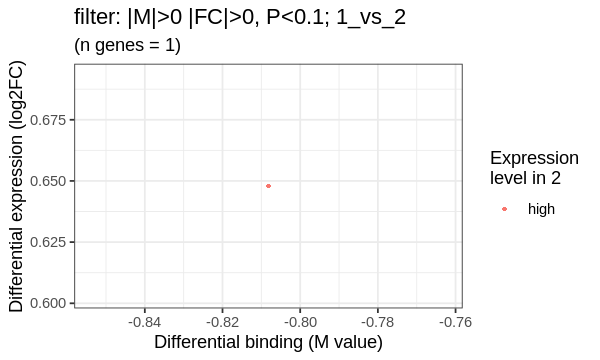

In [22]:
my_data <- filt_res %>% filter(sample == "1") %>% select(feature, M_value, DElog2FC) %>% 
    left_join(select(filter(cnt_res, sample == "2"), feature, category), by = "feature")

p4 <- ggplot(data = my_data) +
    geom_point(aes(x = M_value, y = DElog2FC, color = category, shape = category), size = 1) + 
    labs(title = paste0("filter: |M|>",mnFC," |FC|>",deFC,", P<",pval,"; ", manorm_comp), 
         subtitle = paste0("(n genes = ",n_gen,")"), 
         x = "Differential binding (M value)", 
         y = "Differential expression (log2FC)", 
         shape = "Expression\nlevel in 2", 
         color = "Expression\nlevel in 2") + 
    theme_bw()
p4
ggsave(p4, file = paste0(jup_wd, "figures/peaks_Mval_vs_degFC.tiff"), width = 4.5, height = 5, compression = "lzw")

## 5 - Stats and figures

In [23]:
options(repr.plot.width = 3, repr.plot.height = 2)

### Length of called peaks
#### Basic stats of peak widths

In [24]:
tmp_1 <- select(anno_1, c("peak","width")) %>% unique() %>% select("width")
tmp_2 <- select(anno_2, c("peak","width")) %>% unique() %>% select("width")

full_join(
    tmp_1 %>% summary() %>% str_split_fixed(pattern = ":", n = 2) %>% as_tibble %>% rename(sample1 = 2),
    tmp_2 %>% summary() %>% str_split_fixed(pattern = ":", n = 2) %>% as_tibble %>% rename(sample2 = 2),
    by = "V1"
) %>% rbind(c("n_bases", sum(tmp_1), sum(tmp_2)))

Warning message:
"`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session."


V1,sample1,sample2
<chr>,<chr>,<chr>
Min.,200,200
1st Qu.,900,1200
Median,2400,2000
Mean,3210,3260
3rd Qu.,4100,4200
Max.,21800,21000
n_bases,202200,172800


#### Histogram of peak length

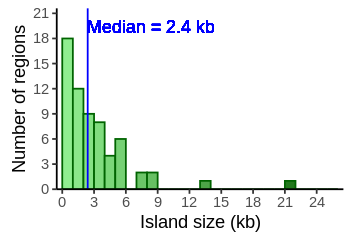

In [25]:
## Sample 1
data <- anno_1 %>% select(width, peak) %>% unique
max_x <- max(data$width) + max(data$width)*0.2
x_lbl_by <- signif(max(data$width)/7, digits = 1)

p2 <- ggplot(data, aes(x=width)) +
  stat_bin(breaks = seq(0,max_x,1000), position="identity") +
  xlim(0, max_x)
pg <- ggplot_build(p2)
max_y <- max(pg$data[[1]]$y) + max(pg$data[[1]]$y)*0.2
y_lbl_by <- signif(max(pg$data[[1]]$y)/6, digits = 1)

pk_med <- anno_1 %>% select(width, peak) %>% unique %>% pull(width) %>% median
p3 <- ggplot(pg$data[[1]], aes(x=x, y=y, fill = x)) +
  geom_bar(stat="identity", color = "darkgreen", width = 1000) +
  scale_x_continuous("Island size (kb)", expand = c(0.02,0),
                     breaks = seq(0, max_x, by = x_lbl_by),
                     labels = seq(0, max_x/1000, by = x_lbl_by/1000)) + 
  scale_y_continuous("Number of regions", expand = c(0,0),
                     limits = c(0, max_y),
                     breaks = seq(0, max_y, by = y_lbl_by)) +
  theme_classic() +
  theme(legend.position="none",
       plot.margin = margin(t = 5, r = 10, b = 5, l = 7, unit = "pt")) + 
  geom_vline(xintercept = pk_med, color = "blue") + 
  geom_text(aes(x = 6000 + pk_med, label=paste0("Median = ",round(pk_med/1000, 2)," kb"), 
                y = max_y - 0.1*max_y), colour="blue", size=3.7) +
  scale_fill_gradient(low="lightgreen", high="darkgreen")
p3
ggsave(p3, file = paste0(jup_wd, "figures/peak_len_hist_1.pdf"), width = 2.5, height = 3 )

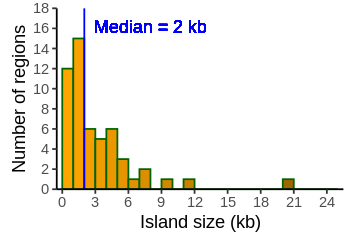

In [26]:
## Sample 2
data <- anno_2 %>% select(width, peak) %>% unique
max_x <- max(data$width) + max(data$width)*0.2
x_lbl_by <- signif(max(data$width)/7, digits = 1)

p2 <- ggplot(data, aes(x=width)) +
  stat_bin(breaks = seq(0,max_x,1000), position="identity") +
  xlim(0, max_x)
pg <- ggplot_build(p2)
max_y <- max(pg$data[[1]]$y) + max(pg$data[[1]]$y)*0.2
y_lbl_by <- signif(max(pg$data[[1]]$y)/6, digits = 1)

pk_med <- anno_2 %>% select(width, peak) %>% unique %>% pull(width) %>% median
p3 <- ggplot(pg$data[[1]], aes(x=x, y=y, fill = x)) +
  geom_bar(stat="identity", color = "darkgreen", width = 1000) +
  scale_x_continuous("Island size (kb)", expand = c(0.02,0),
                     breaks = seq(0, max_x, by = x_lbl_by),
                     labels = seq(0, max_x/1000, by = x_lbl_by/1000)) + 
  scale_y_continuous("Number of regions", expand = c(0,0),
                     limits = c(0, max_y),
                     breaks = seq(0, max_y, by = y_lbl_by)) +
  theme_classic() +
  theme(legend.position="none",
       plot.margin = margin(t = 5, r = 10, b = 5, l = 7, unit = "pt")) + 
  geom_vline(xintercept = pk_med, color = "blue") + 
  geom_text(aes(x = 6000 + pk_med, label=paste0("Median = ",round(pk_med/1000, 2)," kb"), 
                y = max_y - 0.1*max_y), colour="blue", size=3.7) +
  scale_fill_gradient(low="orange1", high="orange4")
p3
ggsave(p3, file = paste0(jup_wd, "figures/peak_len_hist_2.pdf"), width = 2.5, height = 3 )

### Peak annotations

#### Summary of peaks and annotated genes

In [27]:
tot_pk_1 <- select(anno_1, peak, feature) %>% subset(!is.na(.$feature))
tot_pk_2 <- select(anno_2, peak, feature) %>% subset(!is.na(.$feature))

tibble(samples = c("sample1", "sample2"),
       tot_peaks = c(length(unique(anno_1$peak)), length(unique(anno_2$peak))), 
       annot_peaks = c(length(unique(tot_pk_1$peak)), length(unique(tot_pk_2$peak))),
       interactions = c(nrow(tot_pk_1), nrow(tot_pk_2)),
       annot_genes = c(length(unique(tot_pk_1$feature)), length(unique(tot_pk_2$feature))),
       no_annots = c(nrow(filter(anno_1, is.na(feature))), nrow(filter(anno_2, is.na(feature))))
      )

samples,tot_peaks,annot_peaks,interactions,annot_genes,no_annots
<chr>,<int>,<int>,<int>,<int>,<int>
sample1,63,54,82,81,9
sample2,53,50,71,70,3


#### Number of genes spanned by peaks

In [28]:
pk_distr <- full_join(as.data.frame(table(table(tot_pk_1$peak))),
                      as.data.frame(table(table(tot_pk_2$peak))), by = "Var1")  %>% 
  mutate_all(list(~ replace(., is.na(.), 0)))  %>%
  rename(n = 1, s1 = 2, s2 = 3) %>% 
  add_row(n = 0, s1 = nrow(filter(anno_1, is.na(feature))), 
          s2 = nrow(filter(anno_2, is.na(feature))), .before = 1) %>% 
  mutate(n_genes = cut(as.numeric(n),  breaks=c(-Inf,0,1, 5, 10),
                       labels=c("no genes", "1 gene", "2-5 genes", "6-10 genes"))) %>%
  group_by(n_genes) %>% 
  summarise(sample1 = sum(s1), sample2 = sum(s2))
pk_distr

Warning message:
"Column `Var1` joining factors with different levels, coercing to character vector"


n_genes,sample1,sample2
<fct>,<dbl>,<dbl>
no genes,9,3
1 gene,35,37
2-5 genes,19,13


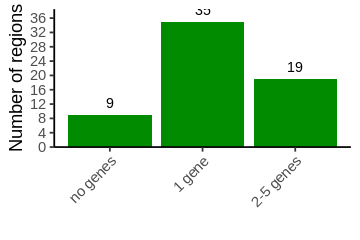

In [29]:
## Sample 1
p2 <- ggplot(pk_distr, aes(x = n_genes, y = sample1)) + 
  geom_bar(stat="identity", position = "identity", fill = "green4") + 
  geom_text(data = pk_distr, aes(label=sample1), vjust=-0.7, color = "black", size = 3) + 
  scale_y_continuous("Number of regions", expand = c(0,0),
                     limits = c(0, 1.1* max(pk_distr$sample1)),
                     breaks = seq(0, 1.1* max(pk_distr$sample1), by = signif(max(pk_distr$sample1)/8, digits = 1))) +
  labs(x = "") + 
  theme_classic()  + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
p2
ggsave(p2, file = paste0(jup_wd, "figures/peak_gene_dens_1.tiff"), compression = "lzw", width = 2.8, height = 2.7 )

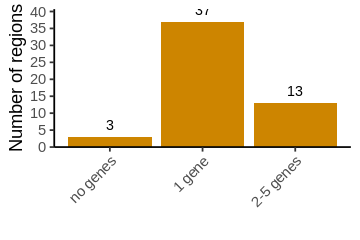

In [30]:
## Sample 2
p2 <- ggplot(pk_distr, aes(x = n_genes, y = sample2)) + 
  geom_bar(stat="identity", position = "identity", fill = "orange3") + 
  geom_text(data = pk_distr, aes(label=sample2), vjust=-0.7, color = "black", size = 3) + 
  scale_y_continuous("Number of regions", expand = c(0,0),
                     limits = c(0, 1.1* max(pk_distr$sample2)),
                     breaks = seq(0, 1.1* max(pk_distr$sample2), by = signif(max(pk_distr$sample2)/8, digits = 1))) +
  labs(x = "") + 
  theme_classic()  + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
p2
ggsave(p2, file = paste0(jup_wd, "figures/peak_gene_dens_2.tiff"), compression = "lzw", width = 2.8, height = 2.7 )

### Preparation of data for ngs.plot
Here, rows that had weird counts on the first run of ngs.plot are removed and those suitable are used to generate new bed files with selected genes.

In [31]:
setwd(paste0(jup_wd, "figures/ngsplot"))

load("plot_genes_s1/heatmap.RData")
lowpk <- enrichList[[1]] %>% abs(.) %>% rowSums %>% subset(. < 10) %>% names %>% 
  str_remove_all(":.") %>% tibble::enframe(value = "feature")
marked_pk <- anno_1 %>% filter(!is.na(feature)) %>% select(feature) %>% unique
ann_bed %>% 
  inner_join(marked_pk, by = "feature") %>%
  anti_join(., lowpk, by = "feature") %>%
  arrange(c2) %>%
  write_tsv(., path = "epic2_marked_genes_1.bed", col_names = FALSE)

load("plot_genes_s2/heatmap.RData")
lowpk <- enrichList[[1]] %>% abs(.) %>% rowSums %>% subset(. < 10) %>% names %>% 
  str_remove_all(":.") %>% tibble::enframe(value = "feature")
marked_pk <- anno_2 %>% filter(!is.na(feature)) %>% select(feature) %>% unique
ann_bed %>% 
  inner_join(marked_pk, by = "feature") %>%
  anti_join(., lowpk, by = "feature") %>%
  arrange(c2) %>%
  write_tsv(., path = "epic2_marked_genes_2.bed", col_names = FALSE)

setwd(jup_wd)

### Other visualizations

Further exporation of data includes multiple options. On this first example, the ChIP density estimated by MAnorm is visualized according to their peak distribution into unique for each sample or common, where density is expected at higher level in the unique peak of their sample. When setting a y limit, some data points may fall aoutside this range and a warning is raised.

In [32]:
options(repr.plot.width = 5, repr.plot.height = 3)

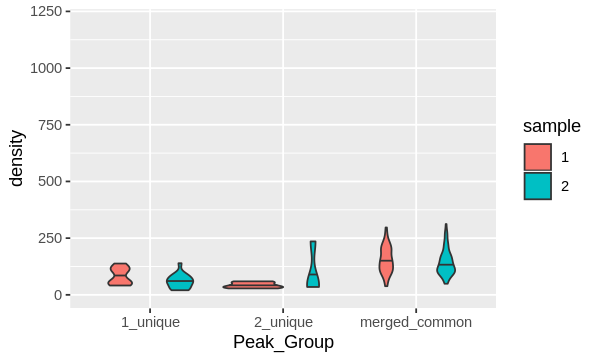

In [33]:
ann_res$density <- as.numeric(ann_res$density)
ggplot() +
    geom_violin(data=ann_res, aes(x = Peak_Group, y = density, fill = sample), draw_quantiles = c(0.5)) + 
    ylim(0, 1200)
ggsave(paste0(jup_wd, "figures/ChIPdens_by_peakGroup.jpg"), width = 5, height = 4)

ChIP density can also be explored by gene expression category combined with direction of differential expression. Here, for a repressive mark, genes with lower expression exhibit higher ChIP density. Note: this is a small sample, `p`val is set to 1 to capture all data.

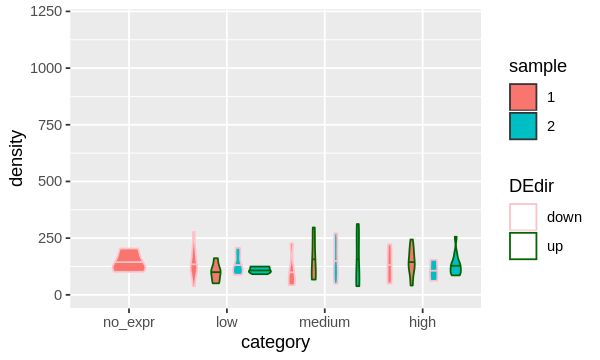

In [34]:
ggplot(data = filter(all_res, !is.na(category), !is.na(peaks), P_value < 1, DEpadj < 1)) +
    geom_violin(aes(x = category, y = density, fill = sample, color = DEdir), draw_quantiles = c(0.5)) +
    ylim(0, 1200) + 
    scale_color_manual(values = c("pink","darkgreen"))
ggsave(paste0(jup_wd, "figures/densBYcateg2.jpg"), width = 5, height = 4)

Also, normalized gene expression is higher in those genes without histone mark.

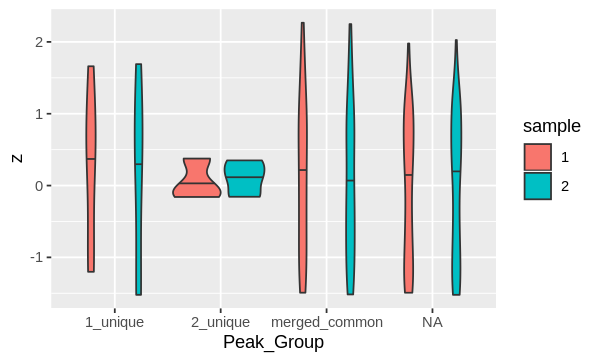

In [35]:
ggplot(data = filter(all_res, !is.na(z))) +
    geom_violin(aes(x = Peak_Group, y = z, fill = sample), draw_quantiles = c(0.5))
ggsave(paste0(jup_wd, "figures/z_by_peakGroup.jpg"), width = 5, height = 4)

A volcano plot helps identify points with desired changes on expression or histone marking, as well as significance of points.

Warning message:
"Removed 76 rows containing missing values (geom_point)."
Warning message:
"Removed 76 rows containing missing values (geom_point)."


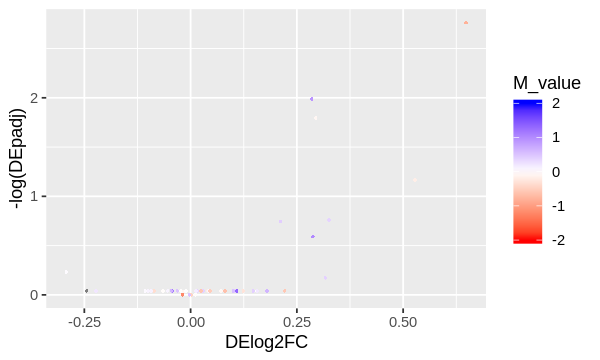

In [36]:
ggplot(filter(all_res, !is.na(M_value), !is.na(DElog2FC))) +
    geom_point(aes(x = DElog2FC, y = -log(DEpadj), color = M_value), stroke = 0, size = 1) + 
    scale_color_gradient2(low = "red", mid="white", high = "blue", limits = c(-2,2))
ggsave(paste0(jup_wd, "figures/rnaseq_volcano.jpg"), width = 5, height = 4)

Another aspect that can be explored, related to peak annotation, is whether there are modifications depending on the position of the peak relative to the gene. Here are plotted density and peak width with very similar results.

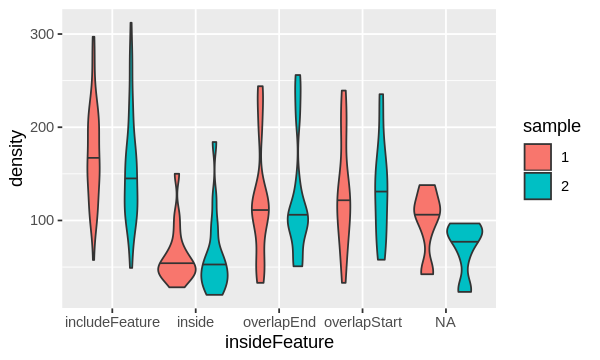

In [37]:
# ChIP density
ggplot() +
    geom_violin(data=all_res %>% filter(!is.na(density)), aes(x = insideFeature, y = density, fill = sample), draw_quantiles = c(0.5))

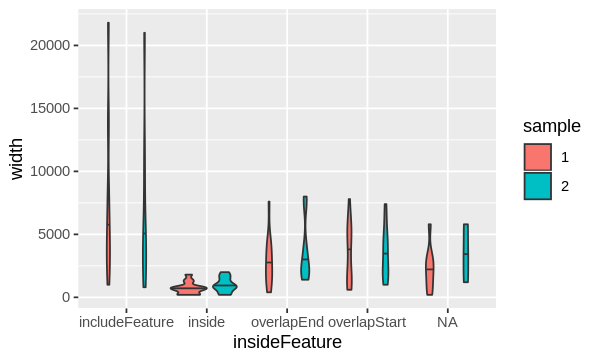

In [38]:
# peak width
epic_res <- bind_rows(mutate(anno_1, sample= "1"), mutate(anno_2, sample= "2"))
ggplot() +
    geom_violin(data=epic_res, aes(x = insideFeature, y = width, fill = sample), draw_quantiles = c(0.5))

Instead of looking at differences in gene expression and histone mark level, their original values may also be used. For this sample, all results by pval are used.

Warning message:
"Removed 5 rows containing missing values (geom_point)."


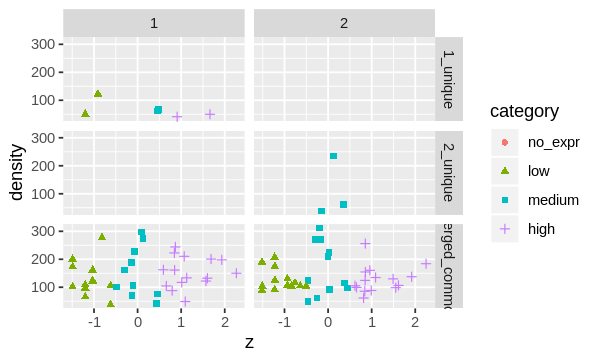

In [39]:
ggplot(all_res %>% filter(!is.na(category), !is.na(peaks), P_value < 1, DEpadj < 1)) + 
    geom_point(aes(x = z, y = density, shape = category, color = category)) + 
    facet_grid( Peak_Group ~ sample)